# Predicción de lluvia en Madrid

### Nicolò Trevisani

## 1. Pre-proceso el dataset

In [1]:
library(keras)

In [2]:
df <- load('Madrid_Alumno.rda') 

In [3]:
df

[1] "xTrain" "xTest"  "yTrain"

In [4]:
n = length(yTrain)
print(n)

[1] 8766


In [5]:
# Preparo la variable de ocurrencia de lluvia
rain = ifelse(yTrain < 1, 0, 1)

# Miro el máximo valor de lluvia, para normalizar la variable 'rain'
# Al final, tengo que acordarme que voy a tener que multiplicar el valor de la predicción en el test para este valor
max.rain <- max(yTrain)
max.rain

# Guardo la predicción original y normalizo
yTrain.original <- yTrain
yTrain <- yTrain / max.rain

[1] 40.6

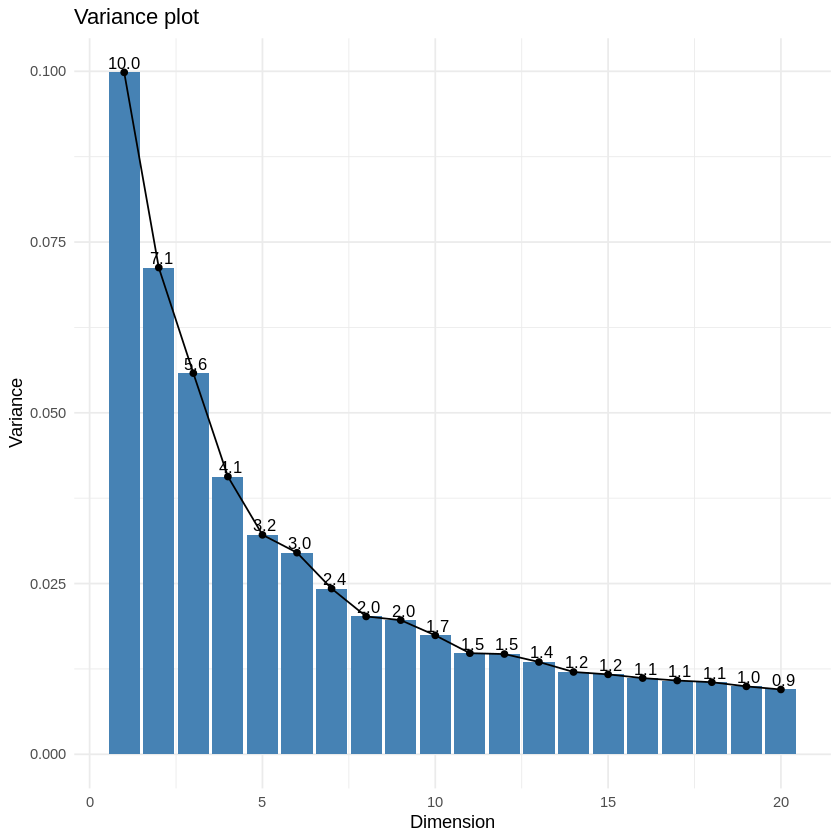

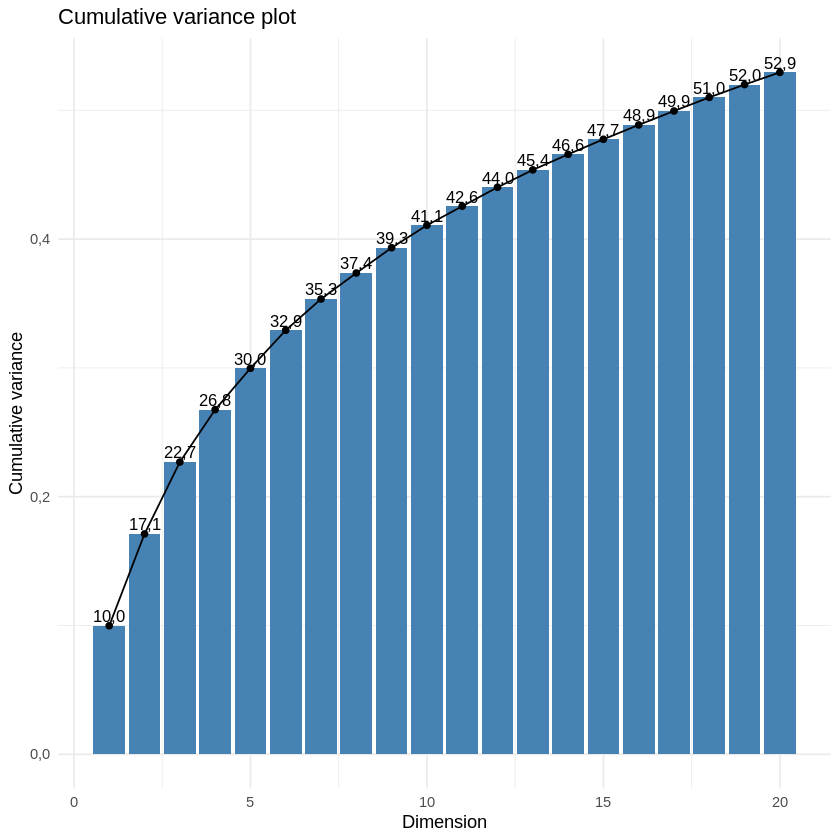

In [6]:
library(ggplot2)

# Miro si puedo reducir la dimensionalidad del problema con PCA
xTrain <- as.data.frame(xTrain)

# Busco las componentes principales
xTrain.pca <- prcomp(xTrain, scale = TRUE, center = TRUE)

# Pinto el porcentage de varianza cumulada explicado por cada componente principal
suma = sum(xTrain.pca$sdev)
plot.pca <- xTrain.pca$sdev / sum(xTrain.pca$sdev)
tot.pca <- length(plot.pca)
pcas <- cbind(plot.pca, 1:tot.pca)
pcas <- as.data.frame(pcas)

# Varianza
ggplot(data=pcas[1:20,],
       aes(x=V2, y = plot.pca, group=1)) + 
       geom_bar(stat="identity", fill="steelblue") +
       geom_text(aes(label=format(round(plot.pca*100,1), nsmall = 1)), vjust=-0.3, size=3.5) +
       geom_line(color="black") +
       geom_point() + 
       ggtitle("Variance plot") +
       labs(y = "Variance", x = "Dimension") +  
       theme_minimal()

# Varianza cumulada
ggplot(data=pcas[1:20,],
       aes(x=V2, y = cumsum(plot.pca), group=1)) + 
       geom_bar(stat="identity", fill="steelblue") +
       geom_text(aes(label=format(round(cumsum(plot.pca*100),1), nsmall = 1)), vjust=-0.3, size=3.5) +
       geom_line(color="black") +
       geom_point() + 
       ggtitle("Cumulative variance plot") +
       labs(y = "Cumulative variance", x = "Dimension") +  
       theme_minimal()

In [7]:
# Considero que el 95% de la varianza es suficiente = 203 componentes principales
print(format(round(cumsum(plot.pca[1:220]*100),1), nsmall = 1))

xTrain.norm <- xTrain.pca$x[, 1:203]

head(xTrain.norm)

  [1] "10,0" "17,1" "22,7" "26,8" "30,0" "32,9" "35,3" "37,4" "39,3" "41,1"
 [11] "42,6" "44,0" "45,4" "46,6" "47,7" "48,9" "49,9" "51,0" "52,0" "52,9"
 [21] "53,8" "54,7" "55,5" "56,3" "57,1" "57,8" "58,6" "59,3" "59,9" "60,5"
 [31] "61,2" "61,8" "62,4" "62,9" "63,5" "64,1" "64,6" "65,1" "65,6" "66,1"
 [41] "66,6" "67,1" "67,5" "68,0" "68,4" "68,9" "69,3" "69,7" "70,1" "70,5"
 [51] "70,8" "71,2" "71,6" "71,9" "72,3" "72,6" "73,0" "73,3" "73,6" "74,0"
 [61] "74,3" "74,6" "74,9" "75,2" "75,5" "75,8" "76,1" "76,4" "76,6" "76,9"
 [71] "77,2" "77,4" "77,7" "78,0" "78,2" "78,5" "78,7" "79,0" "79,2" "79,5"
 [81] "79,7" "79,9" "80,2" "80,4" "80,6" "80,8" "81,0" "81,2" "81,5" "81,7"
 [91] "81,9" "82,1" "82,3" "82,5" "82,7" "82,8" "83,0" "83,2" "83,4" "83,6"
[101] "83,8" "84,0" "84,1" "84,3" "84,5" "84,6" "84,8" "85,0" "85,1" "85,3"
[111] "85,5" "85,6" "85,8" "85,9" "86,1" "86,2" "86,4" "86,5" "86,7" "86,8"
[121] "87,0" "87,1" "87,3" "87,4" "87,5" "87,7" "87,8" "87,9" "88,1" "88,2"
[131] "88,3"

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203
"8,165598","-11,070062","-23,640411","-2,896774","1,2932224","-6,021875","3,1812920","2,4620266","-4,0799272","0,2537715",⋯,"-0,02404365","0,10337553","-0,10288878","-0,065553960","0,046546674","0,08411876","-0,06565152","0,037836940","-0,07044937","0,12426636"
"15,737982","-1,788043","-20,041573","-1,077731","-0,5153748","-8,260207","-1,3229011","2,8292939","-5,0230248","3,6726519",⋯,"0,16097417","-0,16923357","0,12156738","-0,198959275","-0,151663165","-0,02022615","0,15284354","-0,020169320","-0,17614764","0,17615796"
"8,973833","-9,493939","-14,577847","-8,993724","6,9161633","-4,191322","-1,2946483","0,7936730","-1,0061489","3,2487448",⋯,"0,08462146","0,01846252","-0,05996348","-0,151407508","-0,003928607","0,04222168","0,04969379","-0,085897022","-0,02175031","-0,08460788"
"18,767094","-21,626098","-8,201588","-1,301728","-0,9836728","-7,176173","-0,8627923","-0,6491435","-2,1313751","-0,9135046",⋯,"-0,01040451","-0,10844895","0,09648374","0,088899648","0,177180336","-0,29017512","0,05559608","-0,089188422","0,06181285","0,06676483"
"19,782838","-15,985036","5,598262","3,342520","-4,6591668","-6,784047","3,9561486","-0,4631231","-0,1375174","0,3698985",⋯,"0,02232094","-0,14325648","-0,13982655","-0,002794809","0,118278920","0,13868938","-0,02042925","0,021079739","0,16001843","-0,06965988"
"13,121924","-5,915532","10,442003","5,980492","-7,4749319","-8,223955","5,2466005","0,7319028","-1,7877584","2,1665950",⋯,"0,18045131","-0,02017805","0,04405773","0,118522133","0,047281551","0,02881303","-0,14858141","0,007827759","-0,02858634","-0,20388223"


In [8]:
xTrain.norm <- as.data.frame(scale(xTrain.norm))

head(xTrain.norm)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"0,6269804","-1,1909095","-3,247718","-0,5461349","0,3085608","-1,563961","1,0052053","0,9351476","-1,59246429","0,1117187",⋯,"-0,2614556","1,1253889","-1,1334459","-0,7325820","0,52288457","0,9555055","-0,7471668","0,43381542","-0,8155940","1,4492895"
2,"1,2084118","-0,1923564","-2,753310","-0,2031868","-0,1229676","-2,145285","-0,4180023","1,0746462","-1,96057119","1,6168243",⋯,"1,7504664","-1,8423469","1,3392135","-2,2234199","-1,70371633","-0,2297489","1,7394818","-0,23124920","-2,0392653","2,0544892"
3,"0,6890391","-1,0213513","-2,002704","-1,6956057","1,6501853","-1,088542","-0,4090751","0,3014595","-0,39271687","1,4302062",⋯,"0,9201914","0,2009907","-0,6605711","-1,6920170","-0,04413221","0,4795963","0,5655551","-0,98484318","-0,2518039","-0,9867619"
4,"1,4409966","-2,3265205","-1,126734","-0,2454175","-0,2347027","-1,863747","-0,2726199","-0,2465632","-0,83191161","-0,4021553",⋯,"-0,1131408","-1,1806203","1,0628865","0,9934759","1,99036484","-3,2961009","0,6327279","-1,02258039","0,7156088","0,7786627"
5,"1,5189886","-1,7196589","0,769089","0,6301724","-1,1116696","-1,761907","1,2500398","-0,1759073","-0,05367538","0,1628417",⋯,"0,2427225","-1,5595495","-1,5403606","-0,0312327","1,32869262","1,5753735","-0,2325012","0,24168751","1,8525371","-0,8124269"
6,"1,0075427","-0,6363887","1,434522","1,1275148","-1,7835066","-2,135870","1,6577890","0,2779975","-0,69779222","0,9538076",⋯,"1,9622650","-0,2196667","0,4853498","1,3245146","0,53113985","0,3272874","-1,6909753","0,08974834","-0,3309447","-2,3778308"


In [9]:
# Aplico al dataset the test la misma normalización que al dataset de entrenamiento
# https://datascience.stackexchange.com/questions/13971/standardization-normalization-test-data-in-r

trainMean <- apply(xTrain.norm, 2, mean)
trainSd   <- apply(xTrain.norm, 2, sd)

xTest <- as.data.frame(xTest)

xTest.pca <- predict(xTrain.pca, newdata = xTest)
xTest.norm <- xTest.pca[, 1:203]
xTest.norm <- sweep(sweep(xTest.norm, 2L, trainMean), 2, trainSd, "/")

head(xTest.norm)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203
"-0,2375085","-2,249050","-14,145906","-5,918212","7,9073734","-1,416818","-1,1943519","-0,49492482","-2,9302155","2,7376498",⋯,"0,009835242","-0,01099575","-0,09614239","-0,10761343","-0,016282919","0,19455869","-0,11609674","-0,04103585","-0,20875942","-0,06282479"
"-1,8392218","-14,354027","-14,160502","-11,620835","-1,0659593","-1,047623","-3,3585756","-1,64767336","0,3879768","2,2807579",⋯,"0,060193277","-0,04689834","-0,07917066","0,04633864","0,004012527","-0,03912459","-0,07769027","0,03687181","0,02814042","0,11670453"
"5,6095749","-19,723845","-13,432481","-9,818629","-7,4568882","-5,641160","0,1532130","0,52460882","-1,4388447","2,4693210",⋯,"0,078161363","-0,08550688","-0,12301879","0,11194612","0,033711526","-0,01354159","-0,11536005","-0,03740461","0,30308135","0,11165921"
"14,8464104","-10,717722","-10,043190","-2,601557","-5,4842231","-4,787624","0,5279491","2,62527943","-0,8486964","1,5610743",⋯,"0,069462111","-0,09460847","-0,04170988","-0,07355964","0,003973307","0,11333992","-0,02076532","-0,09008077","0,04900509","0,09148561"
"16,6130100","-11,405138","-9,705537","-4,588529","0,6742649","-6,968724","-0,2847626","0,01237023","1,1946678","-0,4866497",⋯,"-0,128881771","-0,13001310","0,13880120","0,14856034","-0,026877552","-0,00154600","0,07248714","0,01954916","-0,05754100","-0,02410496"
"25,3354789","-9,329078","-6,457636","6,498706","0,1281789","-1,283215","-6,3495996","0,32201272","-0,1494864","0,3355503",⋯,"0,171158179","-0,22172405","0,15503683","0,27787772","-0,068437984","0,08935195","0,13390673","0,08820354","0,05371763","0,12992302"


In [10]:
# Dataset de entrenamiento
indtrain   <- sample(1:n, round(0.8*n)) 
x_train    <- xTrain.norm[indtrain,]
y_train    <- yTrain[indtrain]
rain_train <- rain[indtrain]
train      <- x_train

# Añado las variables objetivo
train['y'] <- y_train
train['rain'] <- as.factor(rain_train)

# Miro el dataset
head(train)

nrow(train)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,y,rain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
21,"0,51773721","-1,02641898","1,75447704","-0,557535104","1,2268018","-1,3031368","1,413160594","0,5259060","0,9307861","-2,02785973",⋯,"-0,75791141","-0,4983875","-1,8251004","0,8253649","0,02832048","-0,0146196","0,6124908","0,23322281","0,3965517",1
113,"0,08030622","-0,13799601","-1,71202180","-0,298023906","0,9870512","1,0619176","0,193683277","-0,5324586","-0,8747271","0,11643411",⋯,"-0,05985422","0,1242215","0,4010767","0,9544989","1,32560461","-0,3907852","0,6230823","-0,07195393","0,0000000",0
1467,"-0,46393560","-0,18748565","0,44663234","-2,684833619","-0,8421827","0,3978739","-0,056251853","1,7220689","-0,4715525","0,67313886",⋯,"-2,40345334","0,8465497","0,3874604","-0,1093369","0,05957980","0,5110036","1,8472174","1,37038043","0,0000000",0
2037,"-1,55254960","0,60253369","0,69575146","0,039038478","0,5097535","0,7448401","-0,291108593","-0,4315937","0,9455616","0,05418431",⋯,"0,67200599","-2,8552512","0,6315629","0,3975483","3,47724327","5,2095850","1,0800949","1,54578226","0,0000000",0
7507,"-1,55801211","0,50827864","0,03250115","-0,007275177","-0,7007400","0,0711258","0,009717636","-1,1114278","-0,2419640","-2,21516105",⋯,"0,09807589","0,7396491","0,4962554","1,7920474","0,07400953","-1,5225730","1,1264584","-0,51499840","0,0000000",0
8449,"1,34207670","0,01958625","0,82028009","0,793088288","-1,2324591","-0,8198087","1,113966834","0,8424757","-0,4355641","-0,14177143",⋯,"-1,01976700","0,2274303","-0,2585526","-1,0705278","-0,04244902","0,6144564","1,9251480","1,97163748","0,0000000",0


[1] 7013

In [11]:
# Dataset de validación
x_valid    <- xTrain.norm[-indtrain,]
y_valid    <- yTrain[-indtrain]
rain_valid <- rain[-indtrain]
valid      <- x_valid

# Añado las variables objetivo
valid['y'] <- y_valid
valid['rain'] <- as.factor(rain_valid)

# Miro el dataset
head(valid)

nrow(valid)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,y,rain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,"0,6890391","-1,0213513","-2,0027039","-1,6956057","1,6501853","-1,0885420","-0,4090751","0,3014595","-0,39271687","1,4302062",⋯,"-0,66057112","-1,6920170","-0,04413221","0,4795963","0,5655551","-0,98484318","-0,2518039","-0,9867619","0,18226601",1
7,"0,2829917","-0,4326255","2,1003630","0,5449780","-0,9058046","-1,3230029","1,9734914","0,4837168","-0,91367082","0,7390471",⋯,"-0,53808272","-0,6359470","-1,31791183","1,7843834","-0,5652648","2,33327970","-2,0526094","0,6407929","0,19211823",1
11,"1,2293749","0,1591536","-3,3932754","1,0594533","0,2341337","0,4363116","1,7272687","-1,4538655","0,19651315","-0,5316225",⋯,"0,05248164","-0,7639866","-0,75316709","2,7934819","1,1517056","-1,41302304","-1,7335358","-1,3385246","0,00000000",0
16,"0,7988522","1,1976041","0,4776382","-1,1949955","0,3303271","-1,9807183","-0,5486728","-0,7823749","-0,21319929","-0,1823671",⋯,"1,06903461","2,0512572","-1,99087464","-0,1257575","-1,7176881","2,26320793","1,1752075","2,6529532","0,00000000",0
17,"0,9618708","0,1850292","0,3218902","-1,2308086","0,7778615","-2,0826926","0,1315231","0,1959618","-0,32513824","-1,3150219",⋯,"-1,30492035","0,2751178","-2,79657026","0,5443500","-0,4859580","0,03569487","-1,4745259","0,3463220","0,09852217",1
18,"0,8312430","-1,8088984","0,3699310","-0,4628623","1,7714456","-2,0368881","0,6247909","-0,6558560","-0,02079491","-1,1716652",⋯,"1,30956879","-0,3913998","-0,40247573","0,2347247","0,6130381","-0,63024660","-0,7027324","-0,6639069","0,81034483",1


[1] 1753

In [12]:
# Dataset de test (solo tengo la x, voy a producir la y en el ejercicio)

test <- xTest.norm
head(test)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203
"-0,2375085","-2,249050","-14,145906","-5,918212","7,9073734","-1,416818","-1,1943519","-0,49492482","-2,9302155","2,7376498",⋯,"0,009835242","-0,01099575","-0,09614239","-0,10761343","-0,016282919","0,19455869","-0,11609674","-0,04103585","-0,20875942","-0,06282479"
"-1,8392218","-14,354027","-14,160502","-11,620835","-1,0659593","-1,047623","-3,3585756","-1,64767336","0,3879768","2,2807579",⋯,"0,060193277","-0,04689834","-0,07917066","0,04633864","0,004012527","-0,03912459","-0,07769027","0,03687181","0,02814042","0,11670453"
"5,6095749","-19,723845","-13,432481","-9,818629","-7,4568882","-5,641160","0,1532130","0,52460882","-1,4388447","2,4693210",⋯,"0,078161363","-0,08550688","-0,12301879","0,11194612","0,033711526","-0,01354159","-0,11536005","-0,03740461","0,30308135","0,11165921"
"14,8464104","-10,717722","-10,043190","-2,601557","-5,4842231","-4,787624","0,5279491","2,62527943","-0,8486964","1,5610743",⋯,"0,069462111","-0,09460847","-0,04170988","-0,07355964","0,003973307","0,11333992","-0,02076532","-0,09008077","0,04900509","0,09148561"
"16,6130100","-11,405138","-9,705537","-4,588529","0,6742649","-6,968724","-0,2847626","0,01237023","1,1946678","-0,4866497",⋯,"-0,128881771","-0,13001310","0,13880120","0,14856034","-0,026877552","-0,00154600","0,07248714","0,01954916","-0,05754100","-0,02410496"
"25,3354789","-9,329078","-6,457636","6,498706","0,1281789","-1,283215","-6,3495996","0,32201272","-0,1494864","0,3355503",⋯,"0,171158179","-0,22172405","0,15503683","0,27787772","-0,068437984","0,08935195","0,13390673","0,08820354","0,05371763","0,12992302"


## 2. Preparo el entrenamiento

### Empiezo con la red que discrimina entre lluvia y no lluvia

In [47]:
# Defino el modelo
model.rain <- keras_model_sequential() 

model.rain %>% 
  layer_dense(units = 50, input_shape = ncol(train)-2, activation = "relu", 
              kernel_regularizer = regularizer_l2(0.01)) %>% 
  layer_dropout(0.5) %>%
  layer_dense(units = 10, activation = "relu", kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 2 , activation = "sigmoid")
str(model.rain)

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 50)                      10200       
________________________________________________________________________________
dropout (Dropout)                   (None, 50)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 10)                      510         
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 10)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 2)                       22          
Total params: 10,732
Trainable params: 10,732
Non-trainable params: 0
_____________

In [48]:
# Compilo el modelo
model.rain %>% compile(
  optimizer = optimizer_rmsprop(lr = 0.0005), # optimizer_adagrad(lr = 0.01),
  loss = "binary_crossentropy",
  metrics = list("binary_accuracy","categorical_accuracy","accuracy")
)

`geom_smooth()` using formula 'y ~ x'



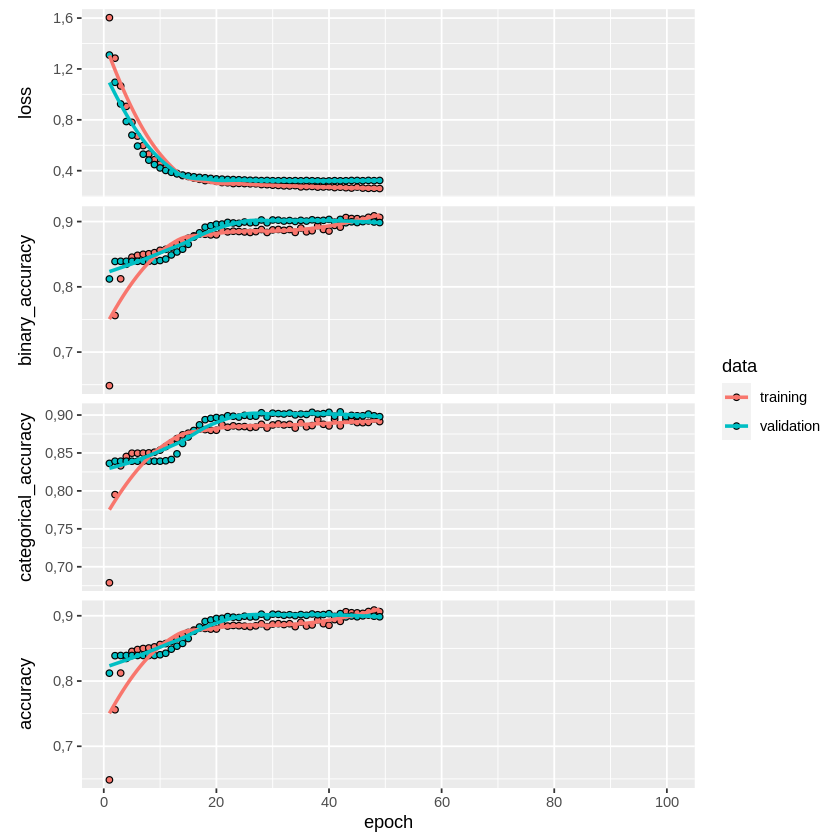

In [49]:
# Entreno el modelo

my.train.x <- as.matrix(train[ , 1:ncol(test)])
my.train.y <- to_categorical(train$rain, 2)

my.valid.x <- as.matrix(valid[ , 1:ncol(test)])
my.valid.y <- to_categorical(valid$rain, 2)

history <- model.rain %>% fit(x = my.train.x, 
                              y = my.train.y, 
                              epochs = 100, 
                              batch_size = 100,
                              validation_data = list(my.valid.x, my.valid.y),
                              callbacks = list(
                              callback_early_stopping(patience = 10),
                              callback_model_checkpoint(filepath=paste0('lluvia_yes_no.h5'),
                                                        monitor = "val_loss", 
                                                        save_best_only = T)))

plot(history)

k_clear_session()

In [50]:
# Pinto la matriz de confusión 
pred.rain <- model.rain %>% predict_classes(my.valid.x)
table(valid$rain, pred.rain)

   pred.rain
       0    1
  0 1427   44
  1  135  147

In [51]:
# Cargo el modelo, para ver si se ha guardado bien
model.rain.loaded <- load_model_hdf5(filepath = "lluvia_yes_no.h5")

pred.rain.loaded <- model.rain.loaded %>% predict_classes(my.valid.x)
table(valid$rain, pred.rain.loaded)

   pred.rain.loaded
       0    1
  0 1431   40
  1  132  150

### Ahora miro la predicción de la cantidad de lluvia

In [18]:
# Defino el modelo
model.quantity <- keras_model_sequential() 

model.quantity %>% 
  layer_dense(units = 1000, input_shape = ncol(train)-2, activation = "relu") %>% #, 
              #kernel_regularizer = regularizer_l2(0.01)) %>% 
  layer_dropout(0.5) %>%

  layer_dense(units = 500, activation = "relu") %>% #, 
              #kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_dropout(0.5) %>%

  layer_dense(units = 200, activation = "relu") %>% #, 
              #kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_dropout(0.5) %>%

layer_dense(units = 1 , activation = "linear")
str(model.quantity)

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 1000)                    204000      
________________________________________________________________________________
dropout (Dropout)                   (None, 1000)                    0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 500)                     500500      
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 500)                     0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 200)                     100200      
________________________________________________________________________________
dr

In [19]:
# Compilo el modelo
model.quantity %>% compile(
  optimizer = optimizer_rmsprop(lr = 0.0001), #optimizer_adagrad(lr = 0.01), #,
  loss = "mse",
)

In [20]:
# Creo los datasets con sólo días de lluvia
quantity.train <- train[train$rain == 1,]
head(quantity.train)

quantity.valid <- valid[valid$rain == 1,]
head(quantity.valid)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,y,rain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
21,"0,5177372","-1,02641898","1,7544770","-0,5575351","1,2268018","-1,3031368","1,4131606","0,5259060","0,93078613","-2,02785973",⋯,"-0,7579114","-0,4983875","-1,82510035","0,8253649","0,02832048","-0,0146196","0,6124908","0,233222805","0,39655172",1
5750,"-0,2574183","-0,08373597","1,4670159","1,8810866","-0,2520098","0,3746908","1,1143206","-0,2202117","-1,25366074","-0,08040992",⋯,"1,2304326","0,5708116","-0,01676243","-0,7864366","-1,17655631","-0,4358269","-0,7527149","-0,827624625","0,09113300",1
3622,"0,1625294","-0,79697551","-0,8477991","-0,8686824","0,6019539","2,4731691","0,7524165","-0,2148488","1,05456362","-0,73589168",⋯,"1,1874744","-1,2214897","-0,28572729","1,1410711","-1,54680972","2,0461163","2,0974723","-0,480834824","0,32512315",1
6892,"0,5621812","-0,46802362","-1,7820981","0,5818506","3,0182830","-1,3776650","0,3275075","1,6834952","-1,22973683","-1,15843166",⋯,"1,2122052","0,5051081","-0,55638693","0,5070197","2,79478289","0,5709653","-1,2739912","-0,009586955","0,54433498",1
2214,"0,4928222","-2,65087067","0,3578744","-0,6588774","1,0226625","-0,7944386","1,4912590","-1,8344866","-0,04375273","-1,40804294",⋯,"-2,3394323","0,2837343","-1,84234915","-0,4382726","-0,96419932","0,5589932","0,5223905","2,081292444","0,04926108",1
4913,"0,2735690","-0,11786093","1,2718998","2,3015281","-0,1411003","-0,9363626","1,3845262","0,1588643","-1,89864946","-0,69273261",⋯,"0,4300750","-0,5839258","-1,46844636","-2,6183438","-0,32876976","-1,1956200","1,2443446","-0,358614670","0,24876847",1


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,y,rain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,"0,6890391","-1,0213513","-2,0027039","-1,6956057","1,6501853","-1,0885420","-0,4090751","0,3014595","-0,39271687","1,4302062",⋯,"-0,6605711","-1,6920170","-0,04413221","0,47959627","0,5655551","-0,98484318","-0,2518039","-0,9867619","0,18226601",1
7,"0,2829917","-0,4326255","2,1003630","0,5449780","-0,9058046","-1,3230029","1,9734914","0,4837168","-0,91367082","0,7390471",⋯,"-0,5380827","-0,6359470","-1,31791183","1,78438336","-0,5652648","2,33327970","-2,0526094","0,6407929","0,19211823",1
17,"0,9618708","0,1850292","0,3218902","-1,2308086","0,7778615","-2,0826926","0,1315231","0,1959618","-0,32513824","-1,3150219",⋯,"-1,3049204","0,2751178","-2,79657026","0,54435000","-0,4859580","0,03569487","-1,4745259","0,3463220","0,09852217",1
18,"0,8312430","-1,8088984","0,3699310","-0,4628623","1,7714456","-2,0368881","0,6247909","-0,6558560","-0,02079491","-1,1716652",⋯,"1,3095688","-0,3913998","-0,40247573","0,23472467","0,6130381","-0,63024660","-0,7027324","-0,6639069","0,81034483",1
26,"0,9299086","-1,7381861","-0,6887915","-0,8534639","1,4655258","-0,7609195","-0,2275564","-0,7674816","0,90820157","-1,1559437",⋯,"0,7929595","-0,8001918","0,38702040","-1,56005281","0,4918114","0,24988958","-0,2969117","0,7759155","0,37684729",1
42,"1,5713481","-2,4065552","0,4118963","1,1078614","0,5519672","0,0602997","0,1026062","-1,9799464","1,43226224","-2,4345495",⋯,"-0,2821873","-0,4957569","-1,64960869","0,01228756","-0,2162388","-0,26719283","0,4493859","-0,8304497","0,35467980",1


`geom_smooth()` using formula 'y ~ x'



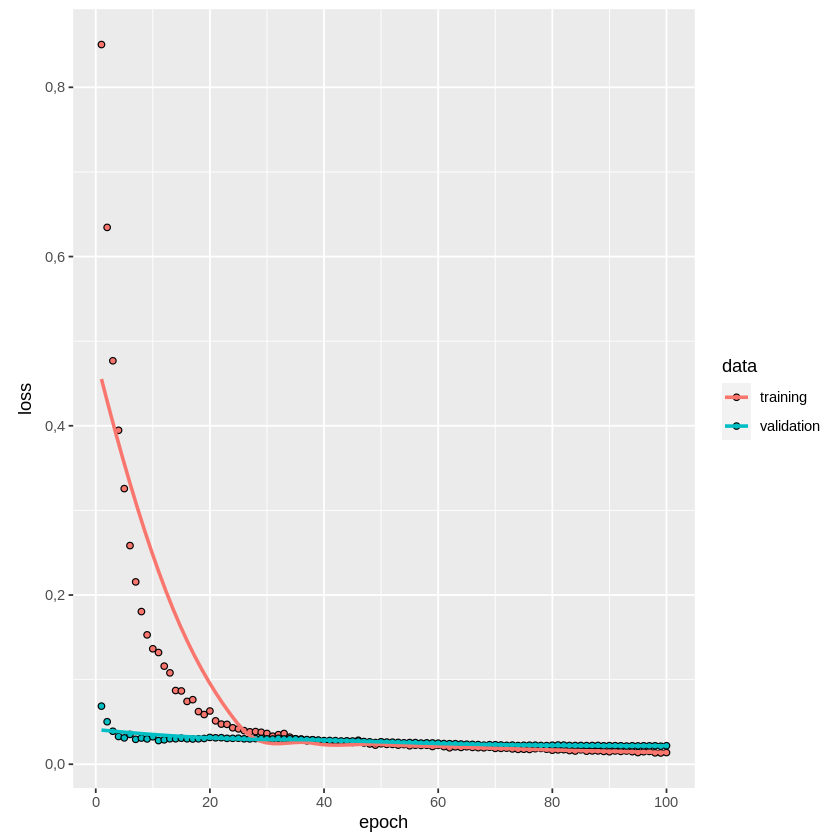

In [21]:
# Entreno el modelo

quantity.train.x <- as.matrix(quantity.train[, 1:ncol(test)])
quantity.train.y <- quantity.train$y

quantity.valid.x <- as.matrix(quantity.valid[, 1:ncol(test)])
quantity.valid.y <- quantity.valid$y

history.quantity <- model.quantity %>% fit(x = quantity.train.x, 
                              y = quantity.train.y, 
                              epochs = 100, 
                              batch_size = 50,
                              validation_data = list(quantity.valid.x, quantity.valid.y),
                              callbacks = list(
                              callback_early_stopping(patience = 50,
                                                      restore_best_weights = T,
                                                      monitor='val_loss'),
                              callback_model_checkpoint(filepath=paste0('lluvia_cantidad.h5'),
                                                        monitor = "val_loss", 
                                                        save_best_only = T))
                              )

plot(history.quantity)

k_clear_session()

In [22]:
# Cargo el modelo de cantidad de lluvia
model.quantity.loaded <- load_model_hdf5(filepath = "lluvia_cantidad.h5")

In [52]:
# Construyo la predicción completa
pred.quantity <- predict(model.quantity.loaded, my.valid.x)
pred.rain.num <- as.numeric(pred.rain.loaded)

pred.quantity.complete <- pred.rain.num * pred.quantity

In [34]:
# RMSE - mejor si es baja
rmse.full <- sqrt(mean((valid$y - as.vector(pred.quantity.complete))^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(valid$y, as.vector(pred.quantity.complete),  method = "spearman")
corr.full

# Ratio de varianzas - mejor si cerca de 1
variance.ratio.full <- var(as.vector(pred.quantity.complete)) / var(valid$y)
variance.ratio.full

[1] 0,07030686

[1] 0,5581177

[1] 0,1947882

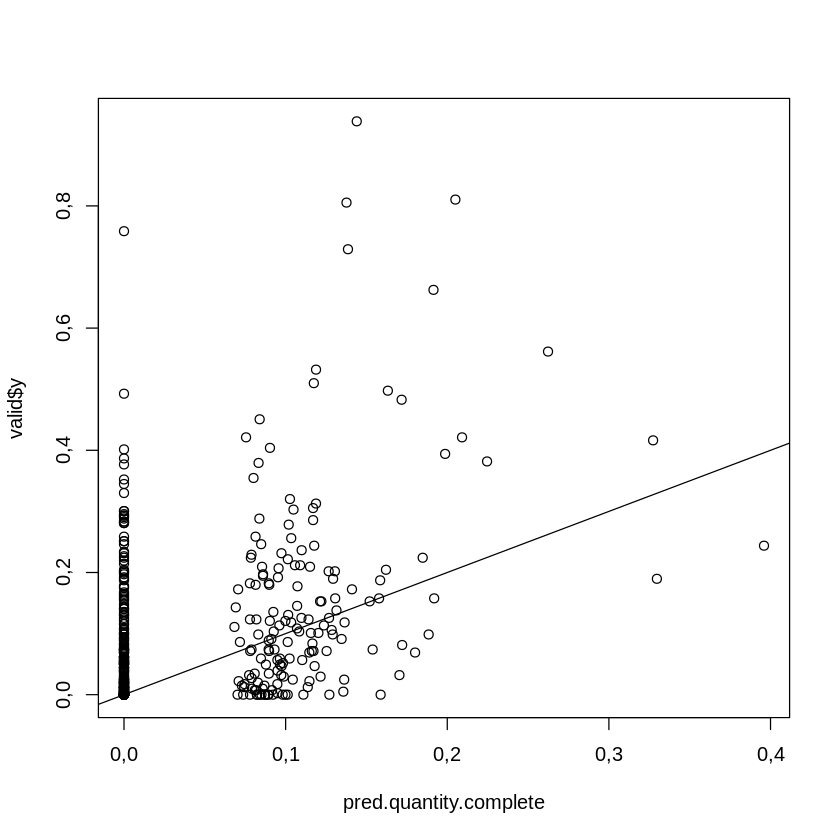

In [35]:
# Pinto los valores original contra la predicción
plot(pred.quantity.complete, valid$y)
abline(0,1)

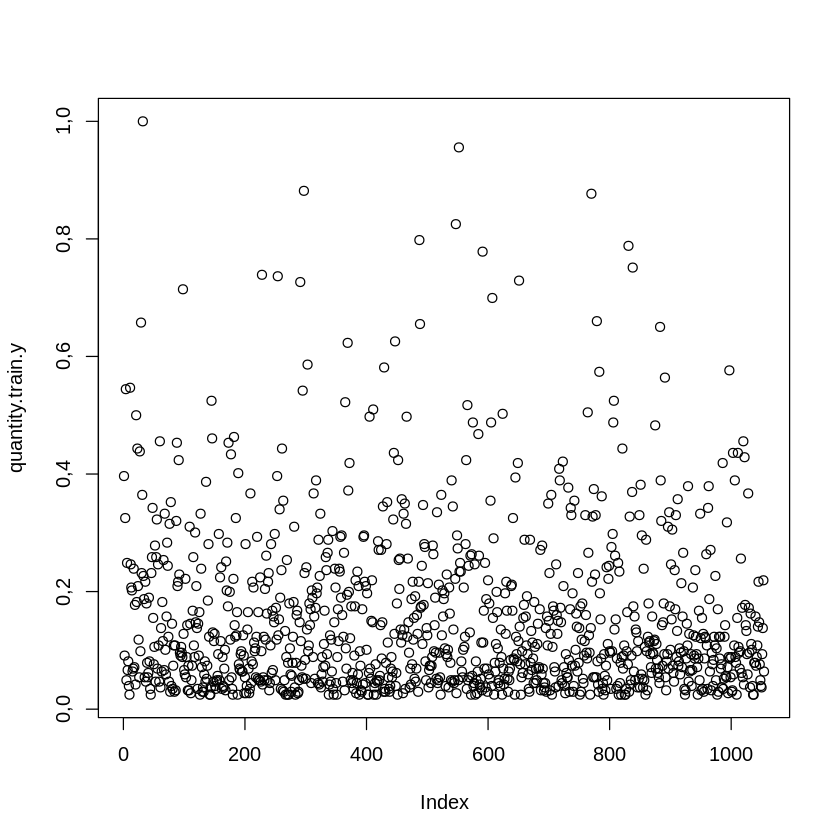

In [36]:
plot(quantity.train.y)

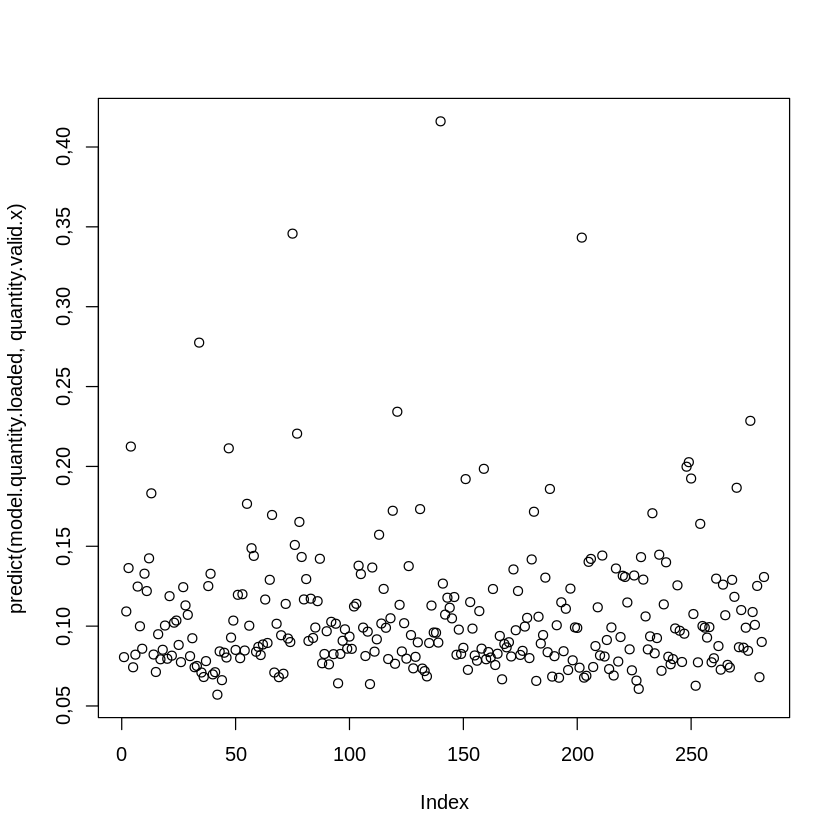

In [37]:
plot(predict(model.quantity.loaded, quantity.valid.x))

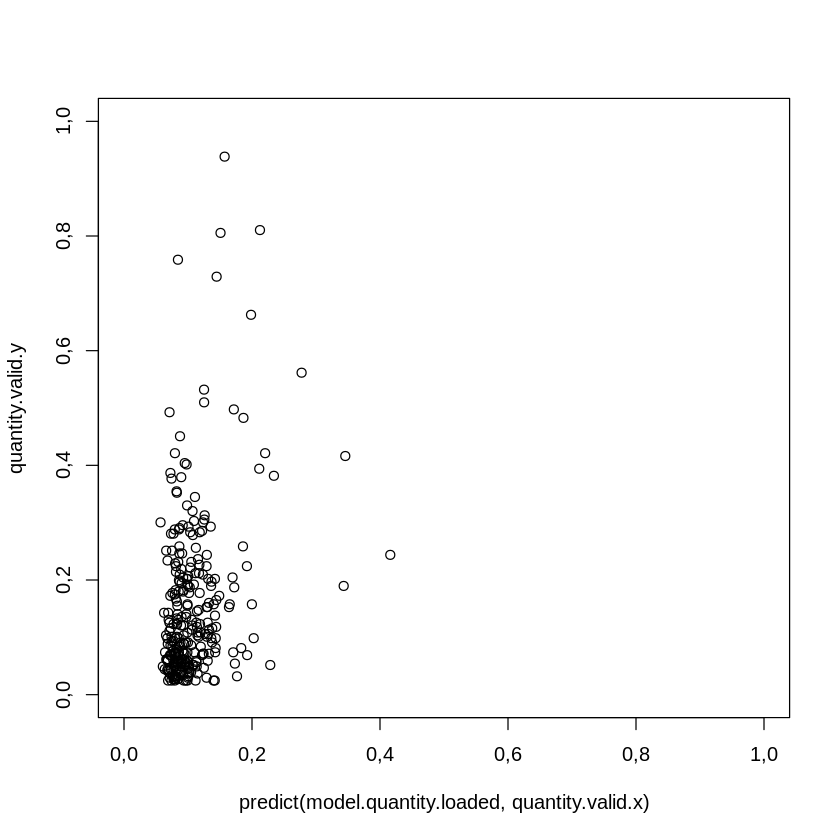

In [38]:
plot(predict(model.quantity.loaded, quantity.valid.x), quantity.valid.y,
    xlim = c(0,1),
    ylim = c(0,1))

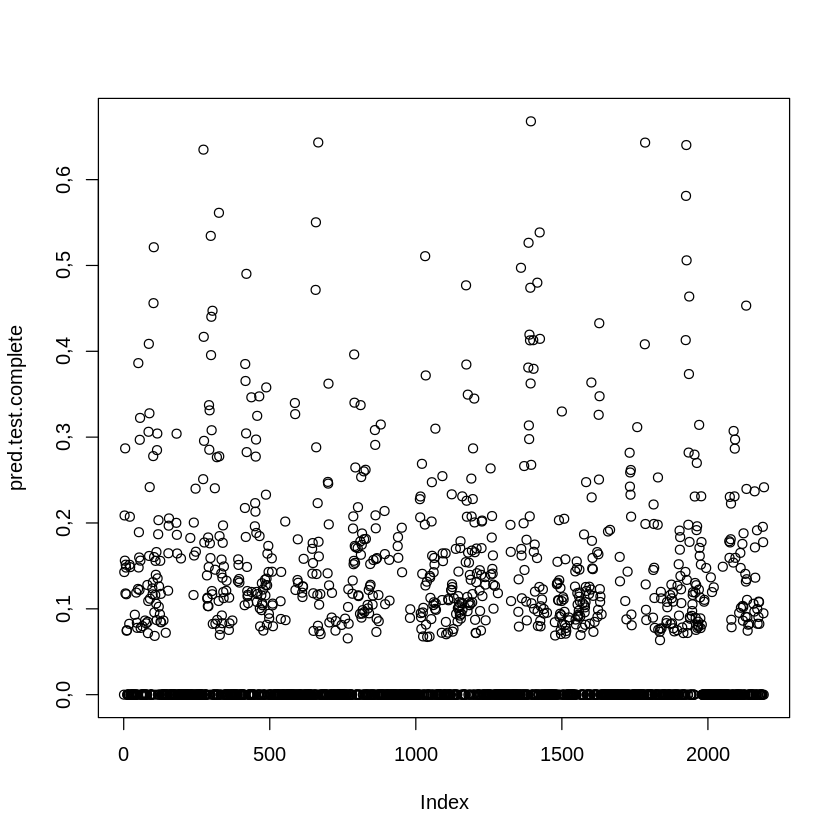

In [39]:
# Computo la predicción sobre el dataset de test
pred.test.lluvia <- model.rain %>% predict_classes(test)
pred.test.quantity <- as.numeric(predict(model.quantity.loaded, test))

pred.test.complete <- pred.test.lluvia * pred.test.quantity
plot(pred.test.complete)

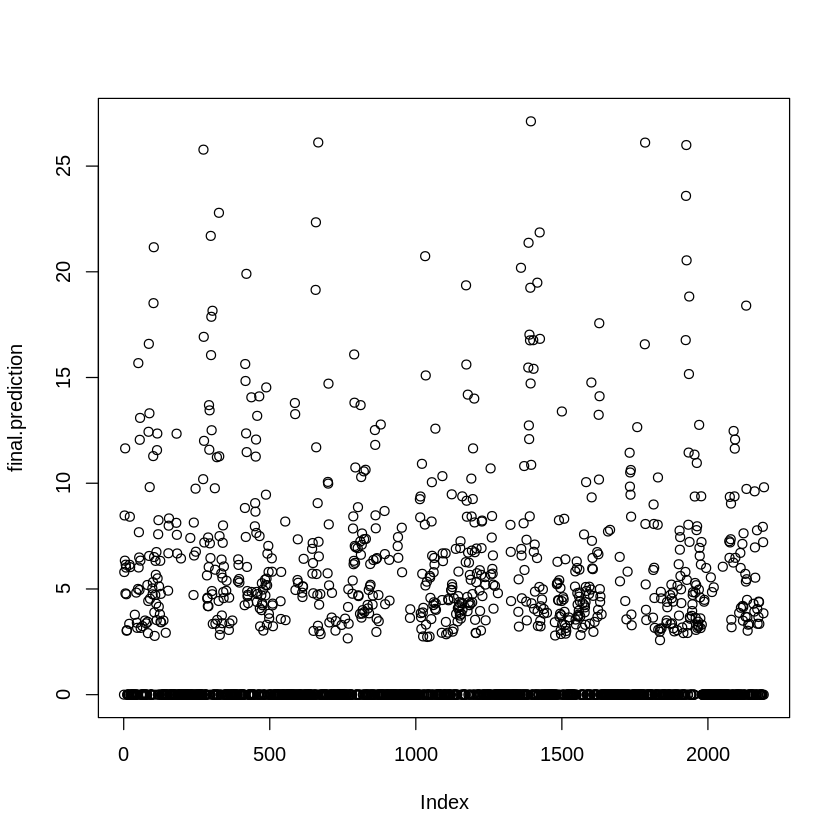

In [69]:
# Vuelvo a las unidades originales
final.prediction <- max.rain * pred.test.complete
plot(final.prediction)

In [72]:
# Guardo el fichero de predicciones
save(final.prediction, file = "yTest.rda")

In [75]:
# Miro si se ha guardado
yTest <- load(file = "yTest.rda")
yTest

[1] "final.prediction"

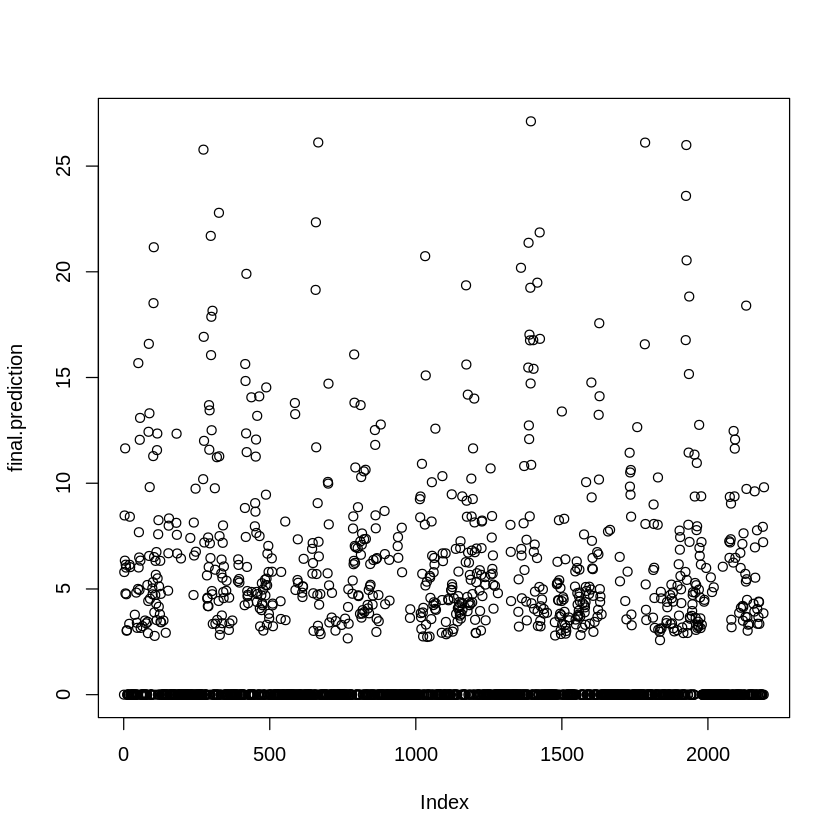

In [74]:
plot(final.prediction)